# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


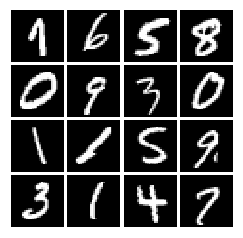

In [27]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [2]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(x, x * alpha)


Test your leaky ReLU implementation. You should get errors < 1e-10

In [3]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [4]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    pass
    return tf.random_uniform([batch_size, dim], -1, 1)


Make sure noise is the correct shape and type:

In [5]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [32]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        pass
#         W1 = tf.get_variable("W1", shape=[784, 256])
#         b1 = tf.get_variable("b1", shape=[256])
#         h1 = tf.matmul(x, W1) + b1
#         h2 = leaky_relu(h1, 0.01)
#         W2 = tf.get_variable("W2", shape=[256, 256])
#         b2 = tf.get_variable("b2", shape=[256])
#         h3 = tf.matmul(h2, W2) + b2
#         h4 = leaky_relu(h3, 0.01)
#         W3 = tf.get_variable("W3", shape=[256, 1])
#         b3 = tf.get_variable("b3", shape=[1])
#         logits = tf.matmul(h4, W3) + b3
        x = tf.layers.dense(x, 256)
        x = leaky_relu(x, 0.01)
        x = tf.layers.dense(x, 256)
        x = leaky_relu(x, 0.01)
        logits = tf.layers.dense(x, 1)
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [33]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [34]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
#         W1 = tf.get_variable("W1", shape=[z.get_shape()[1], 1024])
#         b1 = tf.get_variable("b1", shape=[1024])
#         h1 = tf.matmul(z, W1) + b1
#         h2 = tf.nn.relu(h1)
#         W2 = tf.get_variable("W2", shape=[1024, 1024])
#         b2 = tf.get_variable("b2", shape=[1024])
#         h3 = tf.matmul(h2, W2) + b2
#         h4 = tf.nn.relu(h3)
#         W3 = tf.get_variable("W3", shape=[1024, 784])
#         b3 = tf.get_variable("b3", shape=[784])
#         h5 = tf.matmul(h4, W3) + b3
#         img = tf.nn.tanh(h5)
        z = tf.layers.dense(z, 1024)
        z = tf.nn.relu(z)
        z = tf.layers.dense(z, 1024)
        z = tf.nn.relu(z)
        z = tf.layers.dense(z, 784)
        img = tf.nn.tanh(z)
        return img

Test to make sure the number of parameters in the generator is correct:

In [35]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [46]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    pass
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits=logits_fake))
    D_loss_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits=logits_real))
    D_loss_2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits=logits_fake))
    D_loss = D_loss_1 + D_loss_2
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [37]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [45]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = None
    G_solver = None
    pass
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [39]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [40]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

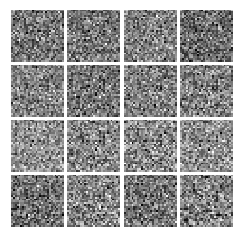


Iter: 0, D: 1.173, G:0.7034
Iter: 50, D: 0.4788, G:1.257
Iter: 100, D: 1.172, G:1.532
Iter: 150, D: 1.294, G:1.262
Iter: 200, D: 1.36, G:0.9164


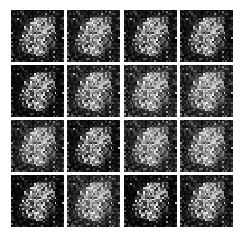


Iter: 250, D: 1.567, G:0.5399
Iter: 300, D: 0.8884, G:1.758
Iter: 350, D: 0.8444, G:1.561
Iter: 400, D: 1.427, G:1.44
Iter: 450, D: 1.117, G:1.413


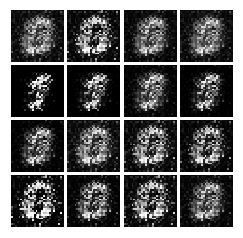


Iter: 500, D: 0.9797, G:2.05
Iter: 550, D: 1.177, G:2.261
Iter: 600, D: 0.918, G:0.9645
Iter: 650, D: 1.13, G:1.142
Iter: 700, D: 1.161, G:1.097


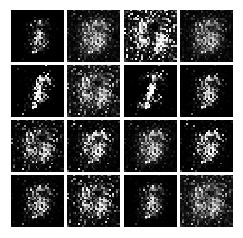


Iter: 750, D: 1.068, G:1.319
Iter: 800, D: 1.325, G:1.31
Iter: 850, D: 1.299, G:0.4403
Iter: 900, D: 1.353, G:2.365
Iter: 950, D: 1.297, G:0.6167


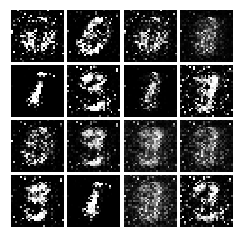


Iter: 1000, D: 1.178, G:1.228
Iter: 1050, D: 1.046, G:1.577
Iter: 1100, D: 1.2, G:1.102
Iter: 1150, D: 1.265, G:0.9821
Iter: 1200, D: 1.017, G:1.234


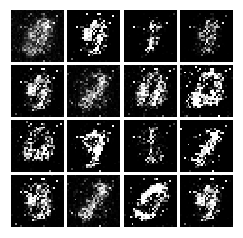


Iter: 1250, D: 1.005, G:1.775
Iter: 1300, D: 1.13, G:1.314
Iter: 1350, D: 1.099, G:1.116
Iter: 1400, D: 1.381, G:0.9618
Iter: 1450, D: 1.263, G:1.08


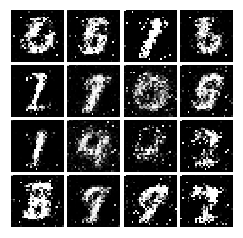


Iter: 1500, D: 1.251, G:1.03
Iter: 1550, D: 1.313, G:0.9223
Iter: 1600, D: 1.235, G:1.055
Iter: 1650, D: 1.331, G:0.9319
Iter: 1700, D: 1.197, G:1.123


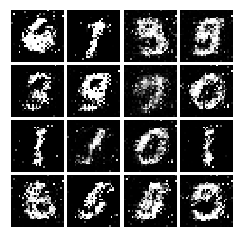


Iter: 1750, D: 1.34, G:0.9987
Iter: 1800, D: 1.465, G:1.599
Iter: 1850, D: 1.205, G:0.9961
Iter: 1900, D: 1.285, G:1.162
Iter: 1950, D: 1.337, G:0.8546


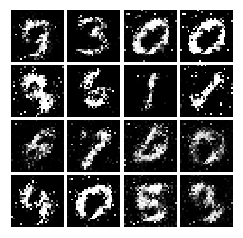


Iter: 2000, D: 1.399, G:0.795
Iter: 2050, D: 1.256, G:0.9295
Iter: 2100, D: 1.347, G:0.8508
Iter: 2150, D: 1.315, G:0.836
Iter: 2200, D: 1.355, G:0.8809


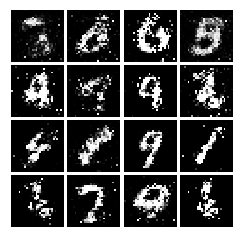


Iter: 2250, D: 2.074, G:0.8966
Iter: 2300, D: 1.351, G:0.8389
Iter: 2350, D: 1.228, G:0.9279
Iter: 2400, D: 1.319, G:0.8367
Iter: 2450, D: 1.297, G:0.8524


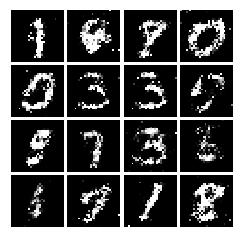


Iter: 2500, D: 1.272, G:0.8592
Iter: 2550, D: 1.396, G:0.9305
Iter: 2600, D: 1.252, G:0.877
Iter: 2650, D: 1.302, G:1.919
Iter: 2700, D: 1.276, G:0.8038


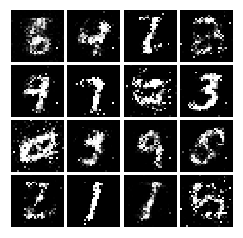


Iter: 2750, D: 1.319, G:1.019
Iter: 2800, D: 1.291, G:0.8796
Iter: 2850, D: 1.249, G:0.8195
Iter: 2900, D: 1.37, G:0.9178
Iter: 2950, D: 1.253, G:0.8116


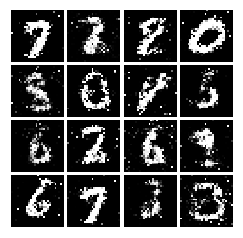


Iter: 3000, D: 1.331, G:0.83
Iter: 3050, D: 1.371, G:0.8049
Iter: 3100, D: 1.389, G:0.7798
Iter: 3150, D: 1.358, G:0.7971
Iter: 3200, D: 1.313, G:0.7535


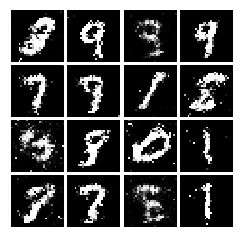


Iter: 3250, D: 1.274, G:0.9116
Iter: 3300, D: 1.319, G:0.9107
Iter: 3350, D: 1.302, G:0.8473
Iter: 3400, D: 1.279, G:0.8221
Iter: 3450, D: 1.268, G:0.8429


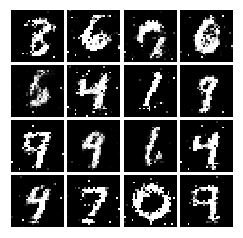


Iter: 3500, D: 1.299, G:0.8276
Iter: 3550, D: 1.331, G:0.8224
Iter: 3600, D: 1.332, G:0.9243
Iter: 3650, D: 1.332, G:0.8048
Iter: 3700, D: 1.376, G:0.9194


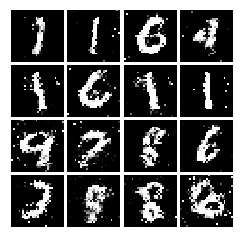


Iter: 3750, D: 1.234, G:1.102
Iter: 3800, D: 1.298, G:0.8661
Iter: 3850, D: 1.294, G:0.9174
Iter: 3900, D: 1.257, G:0.7563
Iter: 3950, D: 1.368, G:0.8019


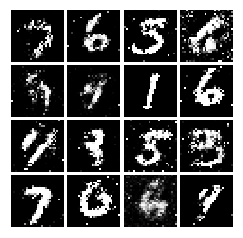


Iter: 4000, D: 1.317, G:0.8308
Iter: 4050, D: 1.341, G:0.8112
Iter: 4100, D: 1.343, G:0.8358
Iter: 4150, D: 1.364, G:0.8243
Iter: 4200, D: 1.339, G:0.8136


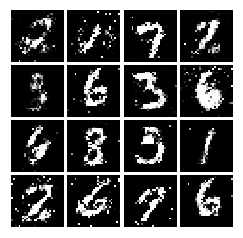


Iter: 4250, D: 1.35, G:0.8278
Final images


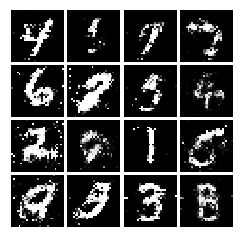

In [41]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [42]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    pass
    G_loss = 0.5 * tf.reduce_mean(tf.square(score_fake - tf.ones_like(score_fake)))
    D_loss = 0.5 * tf.reduce_mean(tf.square(score_real- tf.ones_like(score_real))) + 0.5 * tf.reduce_mean(tf.square(score_fake))
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [43]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [44]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

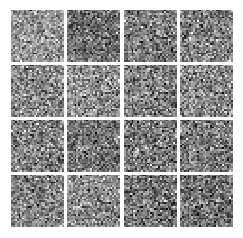


Iter: 0, D: 2.547, G:0.4424
Iter: 50, D: 0.06359, G:0.5545
Iter: 100, D: 0.1288, G:0.6244
Iter: 150, D: 0.4186, G:0.1412
Iter: 200, D: 0.0737, G:0.3865


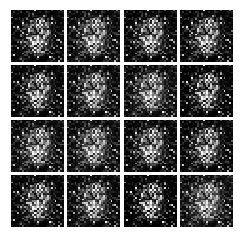


Iter: 250, D: 0.3411, G:0.1182
Iter: 300, D: 0.1292, G:0.5314
Iter: 350, D: 0.2041, G:0.9814
Iter: 400, D: 0.1591, G:0.5985
Iter: 450, D: 0.07951, G:0.3867


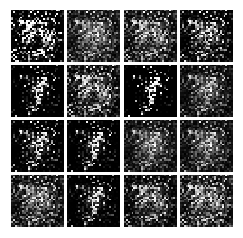


Iter: 500, D: 0.1271, G:0.6939
Iter: 550, D: 0.1274, G:0.5494
Iter: 600, D: 0.4093, G:0.9816
Iter: 650, D: 0.1019, G:0.4167
Iter: 700, D: 0.1261, G:0.4231


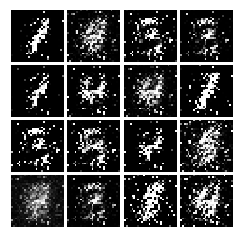


Iter: 750, D: 0.07715, G:0.3964
Iter: 800, D: 0.1134, G:0.3298
Iter: 850, D: 0.09827, G:0.5498
Iter: 900, D: 0.1106, G:0.3147
Iter: 950, D: 0.1203, G:0.2956


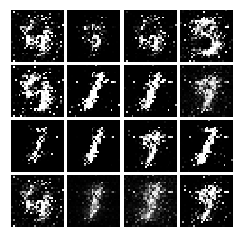


Iter: 1000, D: 1.11, G:0.214
Iter: 1050, D: 0.1052, G:0.3866
Iter: 1100, D: 0.1442, G:0.4729
Iter: 1150, D: 0.157, G:0.3048
Iter: 1200, D: 0.1545, G:0.2957


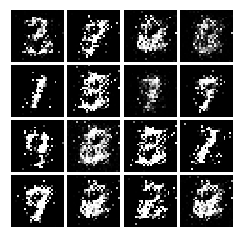


Iter: 1250, D: 0.1693, G:0.3014
Iter: 1300, D: 0.1371, G:0.2676
Iter: 1350, D: 0.1233, G:0.3091
Iter: 1400, D: 0.1562, G:0.3557
Iter: 1450, D: 0.1615, G:0.2533


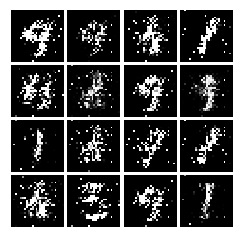


Iter: 1500, D: 0.1576, G:0.2316
Iter: 1550, D: 0.1465, G:0.3125
Iter: 1600, D: 0.1851, G:0.2376
Iter: 1650, D: 0.1745, G:0.2576
Iter: 1700, D: 0.1821, G:0.2655


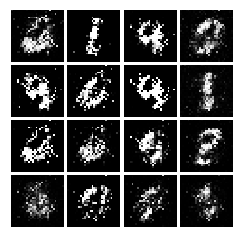


Iter: 1750, D: 0.1933, G:0.209
Iter: 1800, D: 0.2046, G:0.2216
Iter: 1850, D: 0.2116, G:0.2581
Iter: 1900, D: 0.1738, G:0.269
Iter: 1950, D: 0.199, G:0.2698


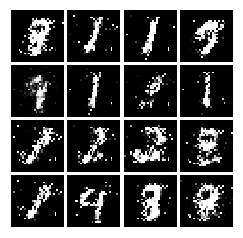


Iter: 2000, D: 0.2121, G:0.1911
Iter: 2050, D: 0.1899, G:0.1967
Iter: 2100, D: 0.1744, G:0.2408
Iter: 2150, D: 0.2047, G:0.1889
Iter: 2200, D: 0.1929, G:0.1981


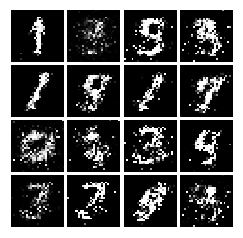


Iter: 2250, D: 0.1943, G:0.2065
Iter: 2300, D: 0.2215, G:0.1915
Iter: 2350, D: 0.208, G:0.1915
Iter: 2400, D: 0.218, G:0.1686
Iter: 2450, D: 0.216, G:0.1889


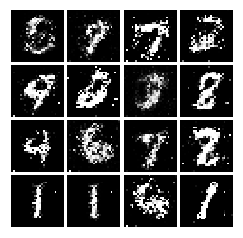


Iter: 2500, D: 0.2286, G:0.1911
Iter: 2550, D: 0.2145, G:0.205
Iter: 2600, D: 0.2346, G:0.1957
Iter: 2650, D: 0.2295, G:0.187
Iter: 2700, D: 0.2296, G:0.1901


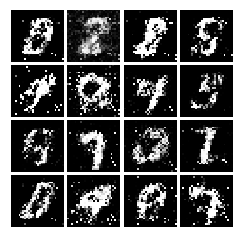


Iter: 2750, D: 0.2439, G:0.1575
Iter: 2800, D: 0.2396, G:0.1806
Iter: 2850, D: 0.2259, G:0.1748
Iter: 2900, D: 0.2215, G:0.1503
Iter: 2950, D: 0.2393, G:0.1876


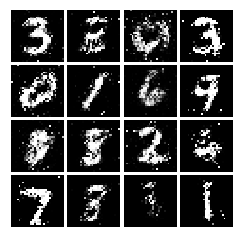


Iter: 3000, D: 0.2319, G:0.1413
Iter: 3050, D: 0.2439, G:0.2024
Iter: 3100, D: 0.2228, G:0.172
Iter: 3150, D: 0.2392, G:0.1394
Iter: 3200, D: 0.229, G:0.1683


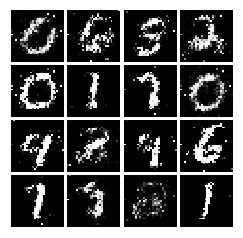


Iter: 3250, D: 0.247, G:0.1674
Iter: 3300, D: 0.2157, G:0.1947
Iter: 3350, D: 0.2399, G:0.1732
Iter: 3400, D: 0.231, G:0.1747
Iter: 3450, D: 0.2208, G:0.1673


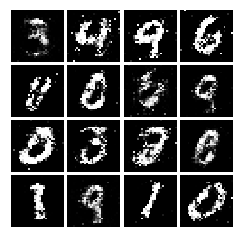


Iter: 3500, D: 0.2428, G:0.1552
Iter: 3550, D: 0.2359, G:0.1728
Iter: 3600, D: 0.2395, G:0.1792
Iter: 3650, D: 0.2391, G:0.1769
Iter: 3700, D: 0.2258, G:0.179


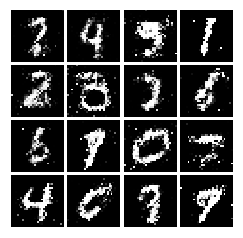


Iter: 3750, D: 0.2261, G:0.1685
Iter: 3800, D: 0.2346, G:0.1525
Iter: 3850, D: 0.2303, G:0.1734
Iter: 3900, D: 0.235, G:0.1633
Iter: 3950, D: 0.2516, G:0.1588


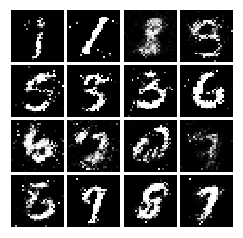


Iter: 4000, D: 0.244, G:0.155
Iter: 4050, D: 0.217, G:0.1767
Iter: 4100, D: 0.2261, G:0.1584
Iter: 4150, D: 0.2256, G:0.1679
Iter: 4200, D: 0.2427, G:0.1617


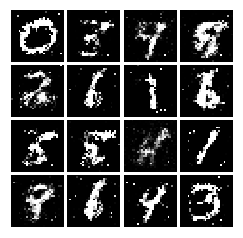


Iter: 4250, D: 0.2279, G:0.1472
Final images


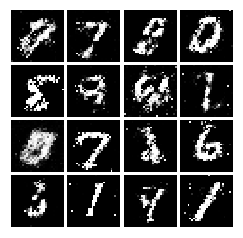

In [45]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

In the beginning, the network outputs similar images for different noise inputs. After further training, the number of classes it starts to generate diversifies.

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [46]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        pass
        init = tf.contrib.layers.xavier_initializer(uniform=True)
        x = tf.reshape(x, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(x, 32, 5, activation=leaky_relu, padding='valid',
                             kernel_initializer=init, name='conv_1')
        x = tf.layers.max_pooling2d(x, 2, 2, padding='same', name='maxpool_1')
        x = tf.layers.conv2d(x, 64, 5, activation=leaky_relu, padding='valid',
                             kernel_initializer=init, name='conv_2')
        x = tf.layers.max_pooling2d(x, 2, 2, padding='same', name='maxpool_2')
        x = tf.reshape(x, [-1, 1024])
        x = tf.layers.dense(x, 1024, activation=leaky_relu, 
                            kernel_initializer=init, name='dense_layer_1')
        logits = tf.layers.dense(x, 1, kernel_initializer=init, name='dense_layer_2')
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [47]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        pass
        init = tf.contrib.layers.xavier_initializer(uniform=True)
        z = tf.layers.dense(z, 1024, activation=tf.nn.relu, kernel_initializer=init, name='dense_layer_1')
        z = tf.layers.batch_normalization(z)
        z = tf.layers.dense(z, 7*7*128, activation=tf.nn.relu, kernel_initializer=init, name='dense_layer_2')
        z = tf.layers.batch_normalization(z)
        z = tf.reshape(z, [-1, 7, 7, 128])
        z = tf.layers.conv2d_transpose(z, 64, 4, strides=2, padding='same', kernel_initializer=init, 
                                       name='convt_1')
        z = tf.layers.batch_normalization(z)
        z = tf.layers.conv2d_transpose(z, 1, 4, strides=2, padding='same', kernel_initializer=init, 
                                       name='convt_2')
        img = tf.tanh(z)
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [48]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

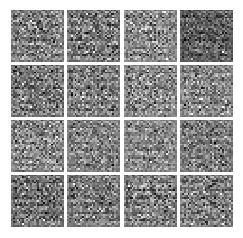


Iter: 0, D: 1.394, G:0.6337
Iter: 50, D: 0.005168, G:5.378
Iter: 100, D: 0.0006563, G:7.385
Iter: 150, D: 0.1546, G:5.207
Iter: 200, D: 0.706, G:3.39


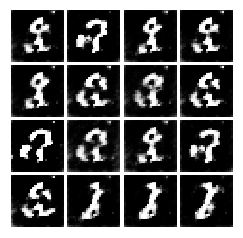


Iter: 250, D: 0.7169, G:2.401
Iter: 300, D: 0.4422, G:2.818
Iter: 350, D: 0.6539, G:1.822
Iter: 400, D: 0.6297, G:4.186
Iter: 450, D: 0.6781, G:4.304


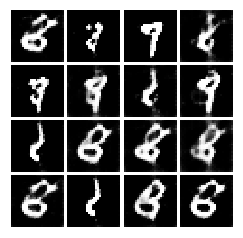


Iter: 500, D: 0.3586, G:2.893
Iter: 550, D: 0.3043, G:3.766
Iter: 600, D: 0.3995, G:2.611
Iter: 650, D: 0.4605, G:2.425
Iter: 700, D: 0.8388, G:5.441


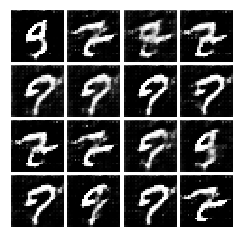


Iter: 750, D: 0.3057, G:4.785
Iter: 800, D: 0.4152, G:3.234
Iter: 850, D: 0.2905, G:3.419
Iter: 900, D: 0.3453, G:2.398
Iter: 950, D: 0.6387, G:7.079


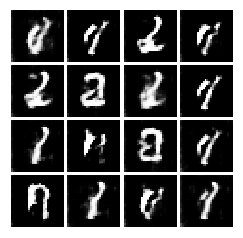


Iter: 1000, D: 0.2732, G:3.418
Iter: 1050, D: 0.4753, G:3.056
Iter: 1100, D: 0.3536, G:3.6
Iter: 1150, D: 0.5593, G:3.21
Iter: 1200, D: 0.5321, G:3.257


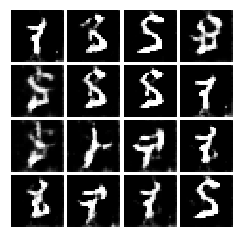


Iter: 1250, D: 0.2328, G:4.817
Iter: 1300, D: 0.5399, G:3.109
Iter: 1350, D: 0.4173, G:4.347
Iter: 1400, D: 0.3901, G:2.392
Iter: 1450, D: 0.311, G:6.072


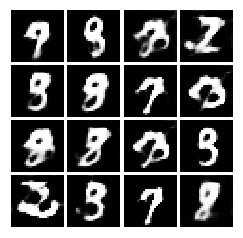


Iter: 1500, D: 0.3415, G:2.892
Iter: 1550, D: 0.2561, G:3.15
Iter: 1600, D: 0.3329, G:2.985
Iter: 1650, D: 0.3889, G:2.493
Iter: 1700, D: 0.3289, G:2.848


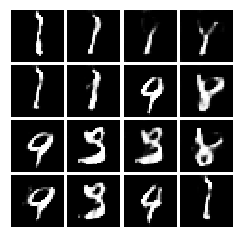


Iter: 1750, D: 0.4556, G:2.003
Iter: 1800, D: 0.5322, G:3.432
Iter: 1850, D: 0.4126, G:3.454
Iter: 1900, D: 0.5103, G:2.688
Iter: 1950, D: 0.515, G:2.547


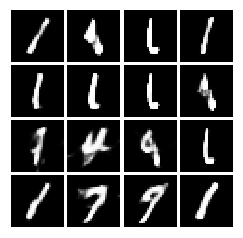


Iter: 2000, D: 0.56, G:1.847
Iter: 2050, D: 0.5821, G:2.196
Iter: 2100, D: 0.5476, G:1.83
Final images


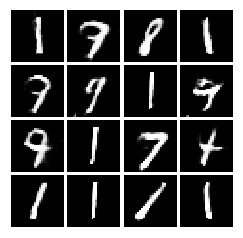

In [49]:
with get_session() as sess:
    with tf.device("/gpu:0"):
        sess.run(tf.global_variables_initializer())
        run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

The images generated by DCGAN are less noisy. The shapes of the digits are much clearer and smoother. I have changed the original loss to the least squares loss as it obtained much better results.

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here

# Implemented Conditional GAN

In [79]:
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=True)

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


In [129]:
def discriminator(x, y):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        pass
        init = tf.contrib.layers.xavier_initializer(uniform=True)
        x = tf.reshape(x, shape=[-1, 28, 28, 1])
        x = tf.concat(axis=3, values=[x, y])
        x = tf.layers.conv2d(x, 32, 5, activation=leaky_relu, padding='valid',
                             kernel_initializer=init, name='conv_1')
        x = tf.layers.max_pooling2d(x, 2, 2, padding='same', name='maxpool_1')
        x = tf.layers.conv2d(x, 64, 5, activation=leaky_relu, padding='valid',
                             kernel_initializer=init, name='conv_2')
        x = tf.layers.max_pooling2d(x, 2, 2, padding='same', name='maxpool_2')
        x = tf.reshape(x, [-1, 1024])
        x = tf.layers.dense(x, 1024, activation=leaky_relu, 
                            kernel_initializer=init, name='dense_layer_1')
        logits = tf.layers.dense(x, 1, kernel_initializer=init, name='dense_layer_2')
        return logits

In [130]:
def generator(z, y):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        pass
        init = tf.contrib.layers.xavier_initializer(uniform=True)
        z = tf.concat(axis=1, values=[y, z])
        z = tf.layers.dense(z, 1024, activation=tf.nn.relu, kernel_initializer=init, name='dense_layer_1')
        z = tf.layers.batch_normalization(z)
        z = tf.layers.dense(z, 7*7*128, activation=tf.nn.relu, kernel_initializer=init, name='dense_layer_2')
        z = tf.layers.batch_normalization(z)
        z = tf.reshape(z, [-1, 7, 7, 128])
        z = tf.layers.conv2d_transpose(z, 64, 4, strides=2, padding='same', kernel_initializer=init, 
                                       name='convt_1')
        z = tf.layers.batch_normalization(z)
        z = tf.layers.conv2d_transpose(z, 1, 4, strides=2, padding='same', kernel_initializer=init, 
                                       name='convt_2')
        img = tf.tanh(z)
        return img

In [131]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96
img_size = 28

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
y_label = tf.placeholder(tf.float32, shape=(None, 10))
y_fill = tf.placeholder(tf.float32, shape=(None, img_size, img_size, 10))
# generated images


with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    G_sample = generator(z, y_label)
    logits_real = discriminator(preprocess_img(x), y_fill)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample, y_fill)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

In [151]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            minibatch,minibatch_y = mnist.train.next_batch(batch_size)
            y_ = np.random.randint(0, 9, (batch_size, 1))
            y_label_ = minibatch_y[y_.astype(np.int32)].reshape([batch_size, 10])
            samples = sess.run(G_sample, {y_label: y_label_})
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minibatch_y = mnist.train.next_batch(batch_size)
        y_label_ = minibatch_y
        y_fill_ = np.ones([batch_size, img_size, img_size, 10]) * (y_label_.reshape([batch_size, 1, 1, 10]))
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch, y_fill: y_fill_, y_label: y_label_})
        y_ = np.random.randint(0, 9, (batch_size, 1))
        y_label_ = np.eye(10)[y_.astype(np.int32)].reshape([batch_size, 10])
        y_fill_ = np.ones([batch_size, img_size, img_size, 10]) * (y_label_.reshape([batch_size, 1, 1, 10]))
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={y_label: y_label_, y_fill: y_fill_})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    minibatch,minibatch_y = mnist.train.next_batch(batch_size)
    y_ = np.random.randint(0, 9, (batch_size, 1))
    y_label_ = minibatch_y[y_.astype(np.int32)].reshape([batch_size, 10])
    samples = sess.run(G_sample, feed_dict={y_label: y_label_})

    fig = show_images(samples[:16])
    plt.show()

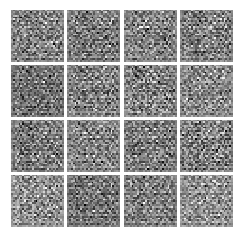


Iter: 0, D: 1.409, G:0.372
Iter: 50, D: 0.1234, G:4.288
Iter: 100, D: 0.1437, G:3.207
Iter: 150, D: 0.8945, G:6.14
Iter: 200, D: 0.845, G:1.832


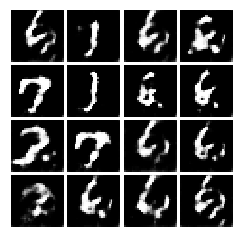


Iter: 250, D: 1.193, G:0.9599
Iter: 300, D: 0.9186, G:0.9183
Iter: 350, D: 0.7163, G:2.147
Iter: 400, D: 0.8236, G:1.776
Iter: 450, D: 0.7478, G:1.143


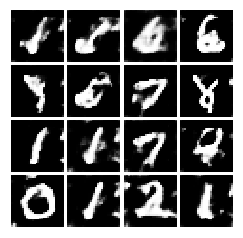


Iter: 500, D: 0.737, G:1.42
Iter: 550, D: 0.9382, G:1.643
Iter: 600, D: 1.063, G:0.6746
Iter: 650, D: 0.9577, G:1.503
Iter: 700, D: 0.9286, G:1.052


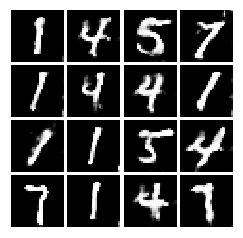


Iter: 750, D: 0.9208, G:1.189
Iter: 800, D: 0.9287, G:1.197
Iter: 850, D: 1.004, G:1.07
Iter: 900, D: 0.9908, G:0.9499
Iter: 950, D: 1.021, G:1.427


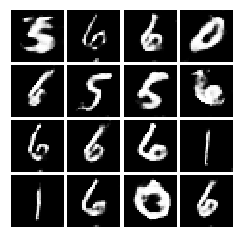


Iter: 1000, D: 1.15, G:1.551
Iter: 1050, D: 1.099, G:1.295
Iter: 1100, D: 1.066, G:0.9753
Iter: 1150, D: 0.9756, G:1.032
Iter: 1200, D: 1.089, G:1.012


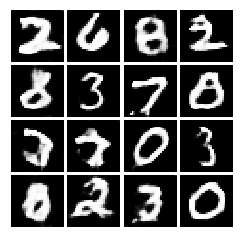


Iter: 1250, D: 1.019, G:1.426
Iter: 1300, D: 0.9822, G:0.8812
Iter: 1350, D: 0.9715, G:1.038
Iter: 1400, D: 1.015, G:0.8048
Iter: 1450, D: 1.061, G:1.098


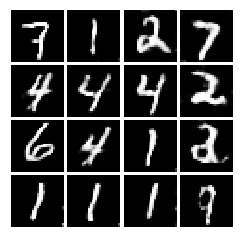


Iter: 1500, D: 0.9466, G:1.074
Iter: 1550, D: 0.9865, G:0.796
Iter: 1600, D: 1.042, G:1.181
Iter: 1650, D: 1.126, G:0.7985
Iter: 1700, D: 0.929, G:1.346


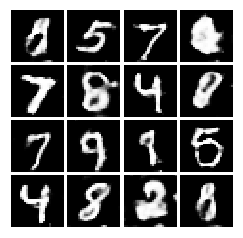


Iter: 1750, D: 1.026, G:0.8899
Iter: 1800, D: 0.9788, G:1.199
Iter: 1850, D: 0.928, G:1.242
Iter: 1900, D: 1.021, G:1.421
Iter: 1950, D: 0.991, G:1.069


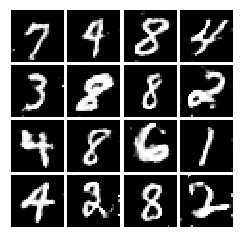


Iter: 2000, D: 0.9895, G:0.9795
Iter: 2050, D: 1.076, G:1.097
Iter: 2100, D: 0.8355, G:1.188
Iter: 2150, D: 0.9692, G:1.122
Iter: 2200, D: 0.8383, G:1.395


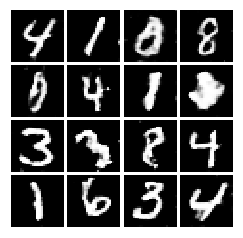


Iter: 2250, D: 1.05, G:0.9631
Iter: 2300, D: 0.8789, G:0.9673
Iter: 2350, D: 0.9226, G:0.9887
Iter: 2400, D: 0.9485, G:1.073
Iter: 2450, D: 0.9972, G:0.9812


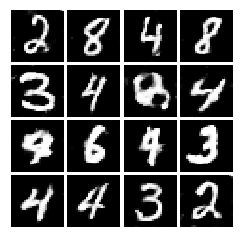


Iter: 2500, D: 0.9445, G:1.539
Iter: 2550, D: 0.773, G:1.291
Iter: 2600, D: 0.8906, G:1.172
Iter: 2650, D: 0.9458, G:1.208
Iter: 2700, D: 0.9222, G:1.4


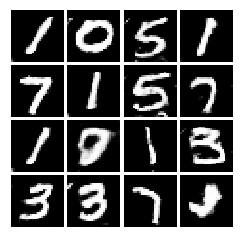


Iter: 2750, D: 0.7772, G:1.654
Iter: 2800, D: 0.923, G:1.401
Iter: 2850, D: 0.7093, G:1.121
Iter: 2900, D: 0.8377, G:1.157
Iter: 2950, D: 0.8198, G:1.568


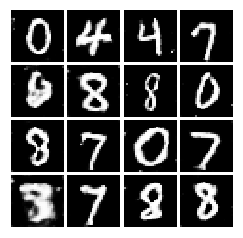


Iter: 3000, D: 0.8138, G:1.598
Iter: 3050, D: 0.9147, G:0.9836
Iter: 3100, D: 0.7502, G:1.528
Iter: 3150, D: 0.7116, G:1.217
Iter: 3200, D: 0.8388, G:1.343


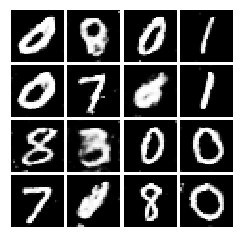


Iter: 3250, D: 0.8445, G:1.97
Iter: 3300, D: 0.7921, G:1.559
Iter: 3350, D: 0.8821, G:1.298
Iter: 3400, D: 0.7897, G:1.301
Iter: 3450, D: 0.9853, G:1.483


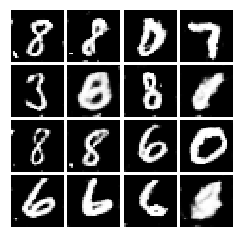


Iter: 3500, D: 0.8309, G:1.161
Iter: 3550, D: 0.8587, G:1.608
Iter: 3600, D: 0.7905, G:1.41
Iter: 3650, D: 0.7289, G:1.222
Iter: 3700, D: 0.7915, G:1.485


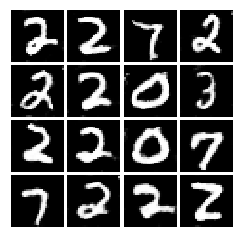


Iter: 3750, D: 0.7763, G:1.465
Iter: 3800, D: 0.7833, G:0.9408
Iter: 3850, D: 0.81, G:1.059
Iter: 3900, D: 0.7188, G:1.272
Iter: 3950, D: 0.742, G:1.182


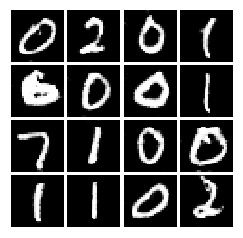


Iter: 4000, D: 0.8559, G:1.314
Iter: 4050, D: 0.6493, G:1.804
Iter: 4100, D: 0.7713, G:2.12
Iter: 4150, D: 0.9412, G:1.851
Iter: 4200, D: 0.7537, G:1.14


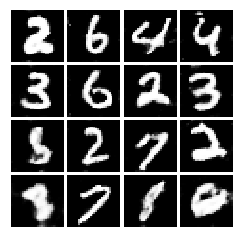


Iter: 4250, D: 0.6715, G:1.369
Iter: 4300, D: 0.809, G:1.117
Iter: 4350, D: 0.8692, G:1.65
Iter: 4400, D: 0.572, G:2.14
Iter: 4450, D: 0.7071, G:1.891


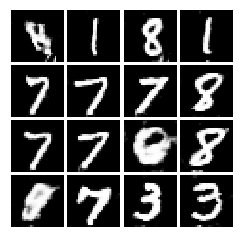


Iter: 4500, D: 0.7351, G:2.392
Iter: 4550, D: 0.729, G:1.133
Iter: 4600, D: 0.6484, G:1.741
Iter: 4650, D: 0.8361, G:1.32
Iter: 4700, D: 0.8107, G:1.007


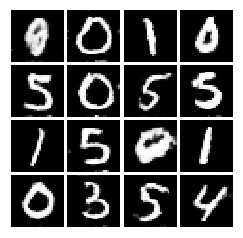


Iter: 4750, D: 0.5992, G:1.476
Iter: 4800, D: 0.6492, G:1.226
Iter: 4850, D: 0.7876, G:1.009
Iter: 4900, D: 0.6654, G:1.749
Iter: 4950, D: 0.6753, G:1.914


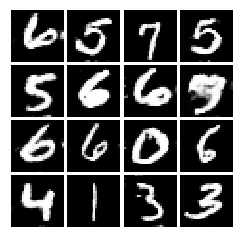


Iter: 5000, D: 0.8948, G:1.31
Iter: 5050, D: 0.782, G:2.551
Iter: 5100, D: 0.6509, G:1.356
Iter: 5150, D: 0.6131, G:2.198
Iter: 5200, D: 0.5978, G:2.123


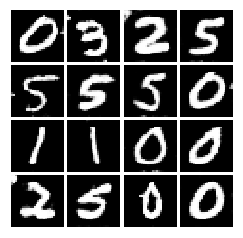


Iter: 5250, D: 0.6139, G:1.876
Iter: 5300, D: 0.7125, G:1.19
Iter: 5350, D: 0.6595, G:1.644
Iter: 5400, D: 0.5859, G:1.937
Iter: 5450, D: 0.9385, G:1.39


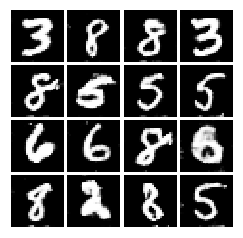


Iter: 5500, D: 0.802, G:1.686
Iter: 5550, D: 0.5321, G:2.042
Iter: 5600, D: 0.7364, G:1.858
Iter: 5650, D: 0.7261, G:1.338
Iter: 5700, D: 1.043, G:2.131


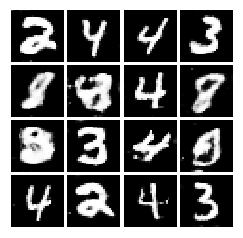


Iter: 5750, D: 0.6002, G:1.742
Iter: 5800, D: 0.5755, G:1.753
Iter: 5850, D: 0.904, G:1.262
Iter: 5900, D: 0.6786, G:1.748
Iter: 5950, D: 0.5322, G:2.044


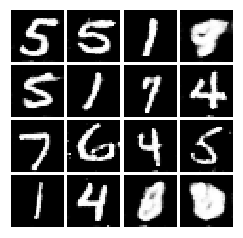


Iter: 6000, D: 0.5083, G:1.622
Iter: 6050, D: 0.4874, G:2.692
Iter: 6100, D: 0.5212, G:2.098
Iter: 6150, D: 0.5742, G:1.645
Iter: 6200, D: 0.5309, G:2.217


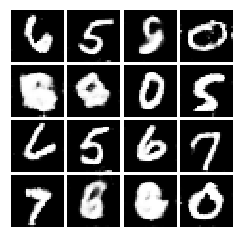


Iter: 6250, D: 0.4995, G:2.414
Iter: 6300, D: 0.5393, G:2.313
Iter: 6350, D: 0.4944, G:2.289
Iter: 6400, D: 0.4377, G:2.4
Iter: 6450, D: 0.5432, G:2.395


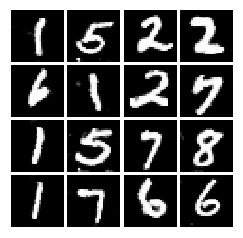


Iter: 6500, D: 0.6553, G:3.26
Iter: 6550, D: 0.5104, G:3.119
Iter: 6600, D: 0.555, G:2.523
Iter: 6650, D: 0.566, G:2.055
Iter: 6700, D: 0.6299, G:2.775


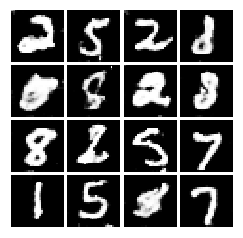


Iter: 6750, D: 0.5852, G:1.755
Iter: 6800, D: 0.4806, G:1.816
Iter: 6850, D: 0.4371, G:2.334
Iter: 6900, D: 0.4791, G:2.335
Iter: 6950, D: 0.4741, G:2.862


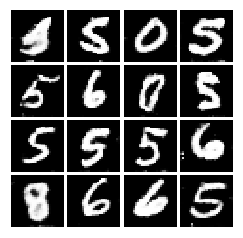


Iter: 7000, D: 0.5408, G:1.405
Iter: 7050, D: 0.6086, G:1.958
Iter: 7100, D: 0.4243, G:2.923
Iter: 7150, D: 0.3789, G:1.808
Iter: 7200, D: 0.96, G:2.183


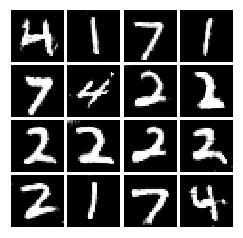


Iter: 7250, D: 0.546, G:1.915
Iter: 7300, D: 0.6006, G:1.736
Iter: 7350, D: 0.4622, G:2.311
Iter: 7400, D: 0.825, G:2.045
Iter: 7450, D: 0.4971, G:1.64


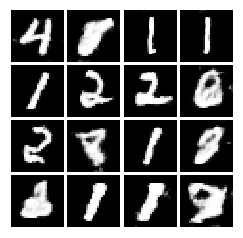


Iter: 7500, D: 0.4264, G:2.361
Iter: 7550, D: 0.4666, G:1.58
Iter: 7600, D: 0.5133, G:1.98
Iter: 7650, D: 0.3825, G:2.631
Iter: 7700, D: 0.4429, G:2.515


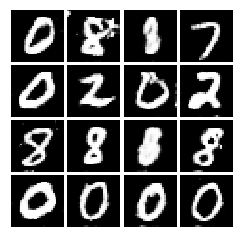


Iter: 7750, D: 0.4191, G:3.05
Iter: 7800, D: 0.4409, G:3.552
Iter: 7850, D: 0.476, G:2.68
Iter: 7900, D: 0.4286, G:2.827
Iter: 7950, D: 0.4685, G:2.441


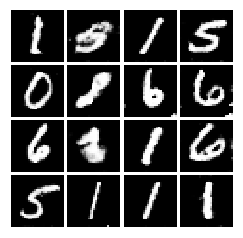


Iter: 8000, D: 0.4523, G:2.164
Iter: 8050, D: 0.3573, G:2.364
Iter: 8100, D: 0.394, G:2.804
Iter: 8150, D: 0.4064, G:2.129
Iter: 8200, D: 0.3998, G:3.109


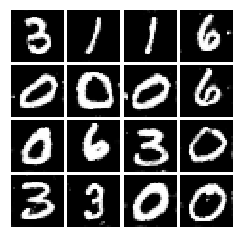


Iter: 8250, D: 0.4022, G:2.702
Iter: 8300, D: 0.3013, G:2.825
Iter: 8350, D: 0.3756, G:2.903
Iter: 8400, D: 0.368, G:1.955
Iter: 8450, D: 0.3577, G:2.668


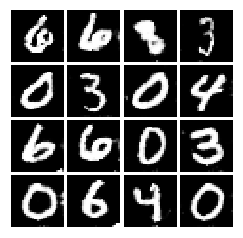


Iter: 8500, D: 0.2861, G:3.3
Iter: 8550, D: 0.5416, G:1.73
Iter: 8600, D: 0.4204, G:2.662
Iter: 8650, D: 0.3377, G:2.623
Iter: 8700, D: 0.5898, G:4.174


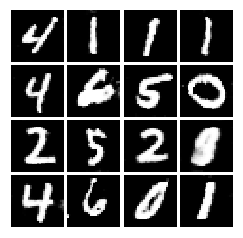


Iter: 8750, D: 0.3926, G:2.166
Iter: 8800, D: 0.5093, G:1.714
Iter: 8850, D: 0.4822, G:2.712
Iter: 8900, D: 0.2757, G:3.441
Iter: 8950, D: 0.4218, G:2.194


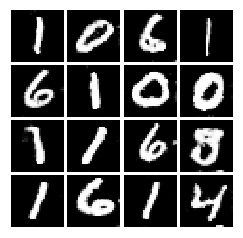


Iter: 9000, D: 0.4163, G:2.174
Iter: 9050, D: 0.3442, G:3.39
Iter: 9100, D: 0.3366, G:2.208
Iter: 9150, D: 0.4355, G:1.628
Iter: 9200, D: 0.4127, G:3.372


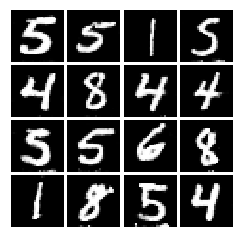


Iter: 9250, D: 0.4089, G:4.296
Iter: 9300, D: 0.2594, G:3.261
Iter: 9350, D: 0.3267, G:3.321
Iter: 9400, D: 0.425, G:3.873
Iter: 9450, D: 0.4034, G:4.131


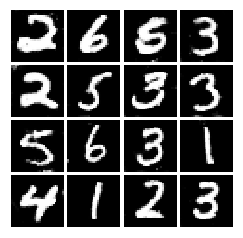


Iter: 9500, D: 0.3382, G:2.283
Iter: 9550, D: 0.2879, G:2.663
Iter: 9600, D: 0.499, G:2.26
Iter: 9650, D: 0.4365, G:2.7
Iter: 9700, D: 0.3883, G:2.012


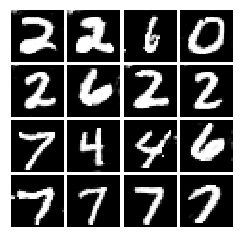


Iter: 9750, D: 0.3169, G:3.306
Iter: 9800, D: 0.3565, G:3.809
Iter: 9850, D: 0.4066, G:3.371
Iter: 9900, D: 0.4479, G:2.987
Iter: 9950, D: 0.3318, G:2.933


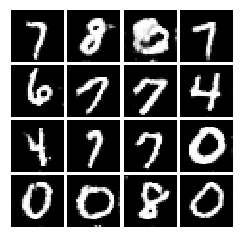


Iter: 10000, D: 0.2982, G:2.704
Iter: 10050, D: 0.3679, G:3.781
Iter: 10100, D: 0.3436, G:3.524
Iter: 10150, D: 0.3074, G:4.295
Iter: 10200, D: 0.3538, G:3.45


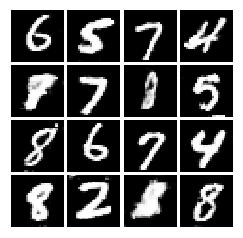


Iter: 10250, D: 0.2746, G:3.5
Iter: 10300, D: 0.2873, G:2.732
Iter: 10350, D: 0.3072, G:3.263
Iter: 10400, D: 0.402, G:4.071
Iter: 10450, D: 0.4214, G:2.286


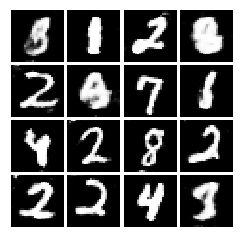


Iter: 10500, D: 0.4058, G:2.801
Iter: 10550, D: 0.3434, G:3.487
Iter: 10600, D: 0.3131, G:2.803
Iter: 10650, D: 0.2704, G:3.902
Iter: 10700, D: 0.4932, G:4.93


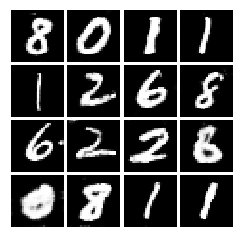


Iter: 10750, D: 0.2578, G:3.861
Iter: 10800, D: 0.2481, G:4.102
Iter: 10850, D: 0.2677, G:3.647
Iter: 10900, D: 0.4894, G:2.757
Iter: 10950, D: 0.3472, G:3.302


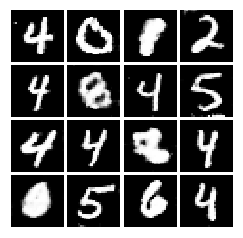


Iter: 11000, D: 0.3115, G:3.159
Iter: 11050, D: 0.2853, G:3.384
Iter: 11100, D: 0.336, G:3.708
Iter: 11150, D: 0.4775, G:2.116
Iter: 11200, D: 0.2761, G:3.83


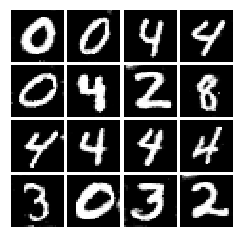


Iter: 11250, D: 0.3454, G:3.369
Iter: 11300, D: 0.2483, G:3.586
Iter: 11350, D: 0.2097, G:4.055
Iter: 11400, D: 0.2614, G:3.776
Iter: 11450, D: 0.2492, G:3.361


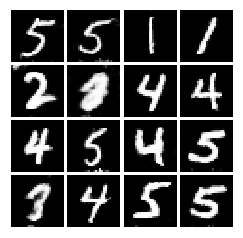


Iter: 11500, D: 0.2843, G:3.881
Iter: 11550, D: 0.571, G:2.797
Iter: 11600, D: 0.4002, G:5.148
Iter: 11650, D: 0.4336, G:4.147
Iter: 11700, D: 0.2576, G:3.806


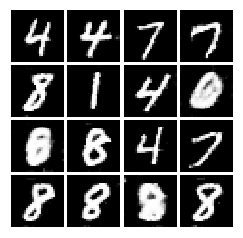


Iter: 11750, D: 0.2667, G:3.436
Iter: 11800, D: 0.2272, G:3.017
Iter: 11850, D: 0.2989, G:3.193
Iter: 11900, D: 0.2832, G:3.156
Iter: 11950, D: 0.2607, G:3.407


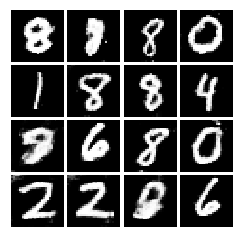


Iter: 12000, D: 0.1918, G:3.484
Iter: 12050, D: 0.5154, G:4.437
Iter: 12100, D: 0.2647, G:3.735
Iter: 12150, D: 0.3067, G:3.615
Iter: 12200, D: 0.2878, G:3.14


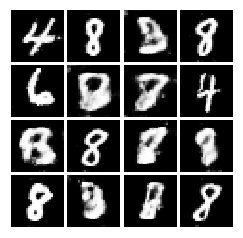


Iter: 12250, D: 0.3133, G:4.003
Iter: 12300, D: 0.3464, G:3.533
Iter: 12350, D: 0.2396, G:3.071
Iter: 12400, D: 0.3216, G:3.329
Iter: 12450, D: 0.3503, G:4.366


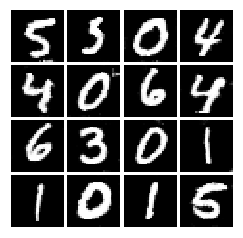


Iter: 12500, D: 0.2411, G:5.324
Iter: 12550, D: 0.2449, G:3.541
Iter: 12600, D: 0.2053, G:3.883
Iter: 12650, D: 0.2531, G:4.196
Iter: 12700, D: 0.5361, G:3.529


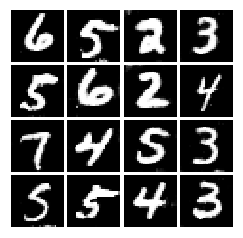


Iter: 12750, D: 0.205, G:4.617
Iter: 12800, D: 0.4189, G:3.39
Iter: 12850, D: 0.4538, G:2.067
Iter: 12900, D: 0.2268, G:3.942
Iter: 12950, D: 0.2491, G:3.295


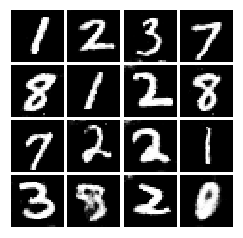


Iter: 13000, D: 0.2211, G:3.895
Iter: 13050, D: 0.2843, G:4.654
Iter: 13100, D: 0.2572, G:4.59
Iter: 13150, D: 0.2433, G:3.811
Iter: 13200, D: 0.2719, G:3.953


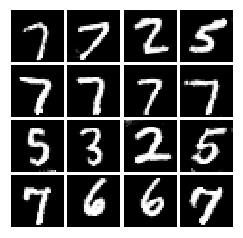


Iter: 13250, D: 0.2502, G:4.232
Iter: 13300, D: 0.2411, G:4.366
Iter: 13350, D: 0.2801, G:3.918
Iter: 13400, D: 0.305, G:4.411
Iter: 13450, D: 0.3009, G:2.712


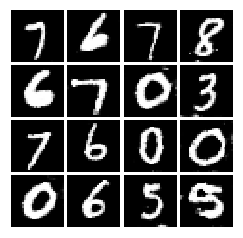


Iter: 13500, D: 0.2475, G:4.365
Iter: 13550, D: 0.1874, G:4.665
Iter: 13600, D: 0.2157, G:5.559
Iter: 13650, D: 0.09923, G:4.502
Iter: 13700, D: 0.216, G:3.035


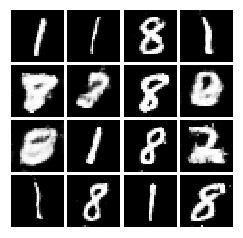


Iter: 13750, D: 0.1698, G:5.062
Iter: 13800, D: 0.2875, G:3.256
Iter: 13850, D: 0.255, G:3.974
Iter: 13900, D: 0.1979, G:5.324
Iter: 13950, D: 0.2988, G:5.173


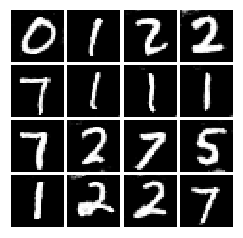


Iter: 14000, D: 0.1724, G:5.048
Iter: 14050, D: 0.1602, G:4.238
Iter: 14100, D: 0.2239, G:4.435
Iter: 14150, D: 0.2151, G:4.256
Iter: 14200, D: 0.2215, G:4.371


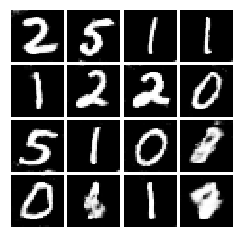


Iter: 14250, D: 0.1431, G:4.009
Iter: 14300, D: 0.2123, G:4.509
Iter: 14350, D: 0.3066, G:3.324
Iter: 14400, D: 0.2623, G:4.643
Iter: 14450, D: 0.3667, G:2.238


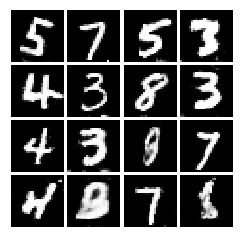


Iter: 14500, D: 0.1601, G:4.412
Iter: 14550, D: 0.2268, G:4.064
Iter: 14600, D: 0.2874, G:3.884
Iter: 14650, D: 0.3992, G:4.944
Iter: 14700, D: 0.2049, G:4.611


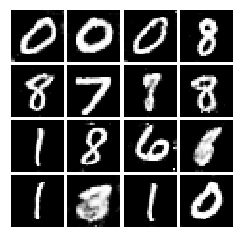


Iter: 14750, D: 0.1975, G:4.661
Iter: 14800, D: 0.187, G:5.332
Iter: 14850, D: 0.248, G:4.155
Iter: 14900, D: 0.241, G:4.296
Iter: 14950, D: 0.1707, G:4.422


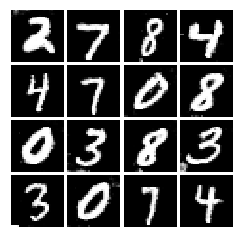


Iter: 15000, D: 0.2003, G:4.518
Iter: 15050, D: 0.3936, G:4.112
Iter: 15100, D: 0.2675, G:3.991
Iter: 15150, D: 0.132, G:3.605
Iter: 15200, D: 0.2975, G:4.344


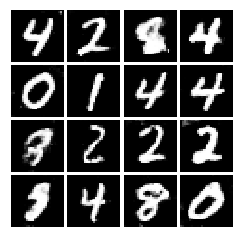


Iter: 15250, D: 0.2201, G:4.588
Iter: 15300, D: 0.1813, G:4.991
Iter: 15350, D: 0.2694, G:3.884
Iter: 15400, D: 0.5022, G:3.895
Iter: 15450, D: 0.2756, G:4.877


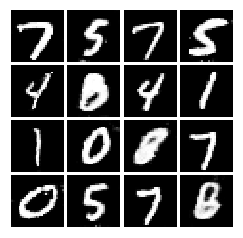


Iter: 15500, D: 0.1971, G:4.874
Iter: 15550, D: 0.1576, G:4.306
Iter: 15600, D: 0.1765, G:3.291
Iter: 15650, D: 0.2003, G:5.213
Iter: 15700, D: 0.2663, G:3.271


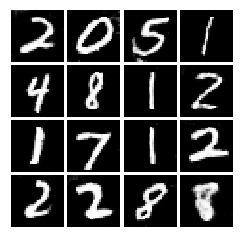


Iter: 15750, D: 0.1295, G:4.872
Iter: 15800, D: 0.3028, G:3.869
Iter: 15850, D: 0.2064, G:4.223
Iter: 15900, D: 0.2053, G:4.621
Iter: 15950, D: 0.228, G:4.33


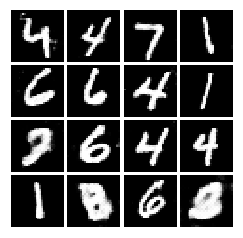


Iter: 16000, D: 0.2816, G:3.252
Iter: 16050, D: 0.1662, G:4.071
Iter: 16100, D: 0.2519, G:5.052
Iter: 16150, D: 0.1804, G:6.232
Iter: 16200, D: 0.1539, G:4.913


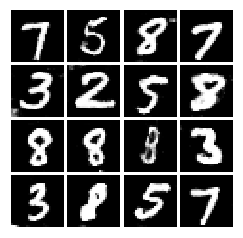


Iter: 16250, D: 0.258, G:5.776
Iter: 16300, D: 0.1329, G:4.756
Iter: 16350, D: 0.2046, G:5.439
Iter: 16400, D: 0.1992, G:3.881
Iter: 16450, D: 0.204, G:4.613


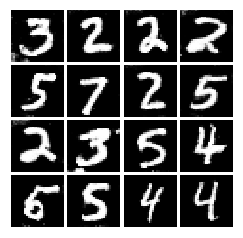


Iter: 16500, D: 0.1816, G:5.182
Iter: 16550, D: 0.2683, G:4.092
Iter: 16600, D: 0.2429, G:4.834
Iter: 16650, D: 0.2327, G:3.297
Iter: 16700, D: 0.2067, G:4.205


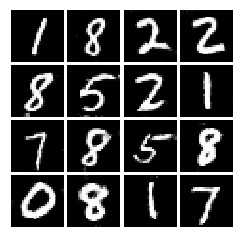


Iter: 16750, D: 0.2153, G:4.185
Iter: 16800, D: 0.2064, G:4.127
Iter: 16850, D: 0.1724, G:4.444
Iter: 16900, D: 0.2001, G:4.762
Iter: 16950, D: 0.1829, G:3.804


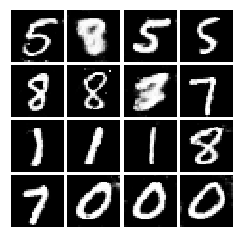


Iter: 17000, D: 0.1818, G:4.978
Iter: 17050, D: 0.1511, G:4.854
Iter: 17100, D: 0.174, G:4.201
Iter: 17150, D: 0.4434, G:7.194
Iter: 17200, D: 0.2635, G:4.132


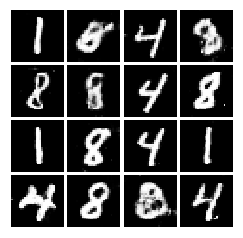


Iter: 17250, D: 0.167, G:4.577
Iter: 17300, D: 0.3232, G:4.998
Iter: 17350, D: 0.2701, G:4.93
Iter: 17400, D: 0.168, G:4.881
Iter: 17450, D: 0.1752, G:4.962


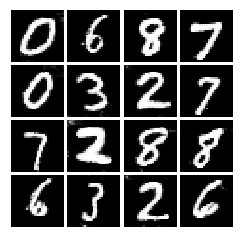


Iter: 17500, D: 0.2227, G:5.248
Iter: 17550, D: 0.1575, G:5.311
Iter: 17600, D: 0.2972, G:5.864
Iter: 17650, D: 0.1794, G:5.187
Iter: 17700, D: 0.2131, G:5.488


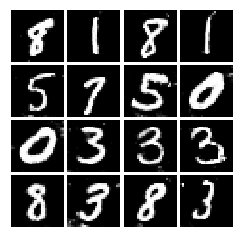


Iter: 17750, D: 0.1921, G:4.068
Iter: 17800, D: 0.1514, G:4.377
Iter: 17850, D: 0.2714, G:4.186
Iter: 17900, D: 0.1076, G:5.757
Iter: 17950, D: 0.2163, G:4.279


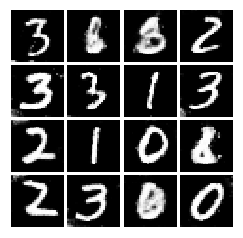


Iter: 18000, D: 0.2321, G:6.56
Iter: 18050, D: 0.1989, G:4.085
Iter: 18100, D: 0.3134, G:6.17
Iter: 18150, D: 0.3552, G:5.186
Iter: 18200, D: 0.2203, G:5.459


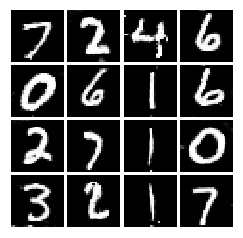


Iter: 18250, D: 0.3562, G:4.5
Iter: 18300, D: 0.26, G:7.161
Iter: 18350, D: 0.1451, G:5.328
Iter: 18400, D: 0.2135, G:4.376
Iter: 18450, D: 0.1413, G:5.581


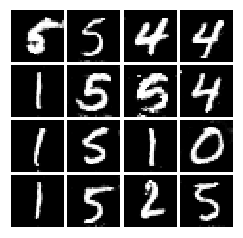


Iter: 18500, D: 0.1122, G:4.851
Iter: 18550, D: 0.1857, G:5.452
Iter: 18600, D: 0.1449, G:5.402
Iter: 18650, D: 0.2179, G:5.304
Iter: 18700, D: 0.1128, G:5.581


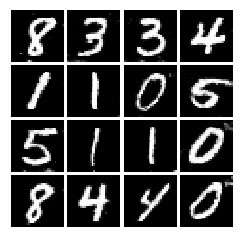


Iter: 18750, D: 0.1725, G:4.43
Iter: 18800, D: 0.1616, G:6.206
Iter: 18850, D: 0.111, G:4.775
Iter: 18900, D: 0.1309, G:5.611
Iter: 18950, D: 0.1803, G:5.993


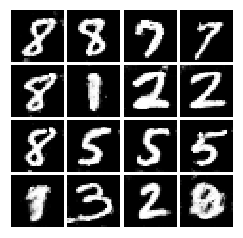


Iter: 19000, D: 0.1769, G:6.871
Iter: 19050, D: 0.2069, G:5.588
Iter: 19100, D: 0.1144, G:5.409
Iter: 19150, D: 0.3449, G:4.474
Iter: 19200, D: 0.1055, G:5.125


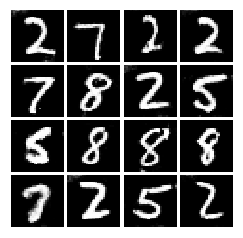


Iter: 19250, D: 0.1341, G:5.452
Iter: 19300, D: 0.3523, G:7.033
Iter: 19350, D: 0.2051, G:4.998
Iter: 19400, D: 0.2283, G:5.715
Iter: 19450, D: 0.1688, G:6.641


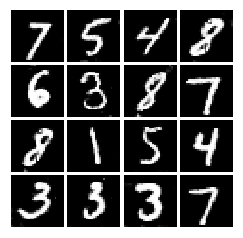


Iter: 19500, D: 0.1644, G:5.016
Iter: 19550, D: 0.2219, G:4.635
Iter: 19600, D: 0.1281, G:4.683
Iter: 19650, D: 0.1968, G:5.999
Iter: 19700, D: 0.2125, G:4.268


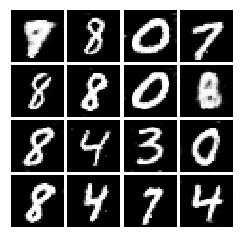


Iter: 19750, D: 0.3233, G:5.893
Iter: 19800, D: 0.1134, G:6.25
Iter: 19850, D: 0.1419, G:5.926
Iter: 19900, D: 0.1715, G:5.617
Iter: 19950, D: 0.2481, G:4.812


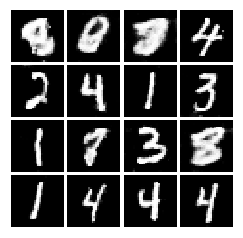


Iter: 20000, D: 0.08101, G:5.557
Iter: 20050, D: 0.2142, G:6.623
Iter: 20100, D: 0.2065, G:5.081
Iter: 20150, D: 1.389, G:8.146
Iter: 20200, D: 0.1535, G:5.804


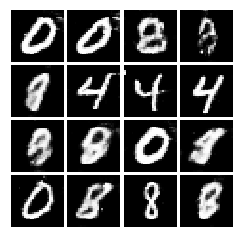


Iter: 20250, D: 0.2548, G:4.979
Iter: 20300, D: 0.1911, G:5.775
Iter: 20350, D: 0.3244, G:3.836
Iter: 20400, D: 0.1765, G:5.568
Iter: 20450, D: 0.1152, G:5.603


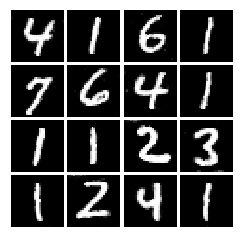


Iter: 20500, D: 0.1406, G:5.858
Iter: 20550, D: 0.1659, G:5.252
Iter: 20600, D: 0.1725, G:5.446
Iter: 20650, D: 0.1895, G:5.153
Iter: 20700, D: 0.1276, G:5.865


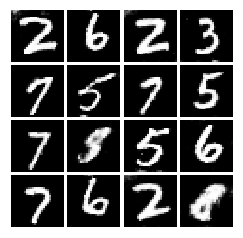


Iter: 20750, D: 0.1665, G:5.72
Iter: 20800, D: 0.1868, G:5.118
Iter: 20850, D: 0.2415, G:6.001
Iter: 20900, D: 0.1373, G:4.718
Iter: 20950, D: 0.1841, G:5.687


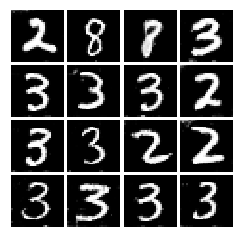


Iter: 21000, D: 0.1115, G:5.578
Iter: 21050, D: 0.1812, G:7.281
Iter: 21100, D: 0.1508, G:4.146
Iter: 21150, D: 0.2525, G:5.446
Iter: 21200, D: 0.3001, G:5.413


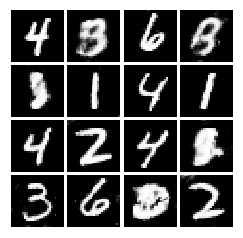


Iter: 21250, D: 0.195, G:4.842
Iter: 21300, D: 0.137, G:5.434
Iter: 21350, D: 0.1945, G:6.096
Iter: 21400, D: 0.1436, G:5.998
Iter: 21450, D: 0.2271, G:4.442
Final images


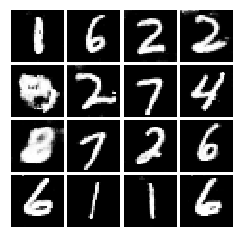

In [152]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=50)

# CIFAR GAN

In [84]:
from cs231n.data_utils import load_CIFAR10
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
X_train /= 255.0
X_test /= 255.0
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 32, 32, 3)
Train labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [85]:
def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)
    for i in range(images.shape[0]):    
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        plt.imshow((255*images[i]).astype('uint8'))
    return

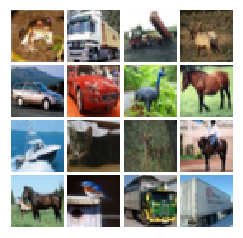

In [86]:
show_images(X_train[:16])

In [87]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        pass
        init = tf.contrib.layers.xavier_initializer(uniform=False)
        x = tf.layers.batch_normalization(tf.layers.conv2d(x, 32, 5, activation=leaky_relu, padding='same',
                             kernel_initializer=init, name='conv_1'))
        x = tf.layers.batch_normalization(tf.layers.conv2d(x, 64, 5, activation=leaky_relu, padding='same',
                             kernel_initializer=init, name='conv_2'))
        x = tf.layers.batch_normalization(tf.layers.conv2d(x, 128, 5, activation=leaky_relu, padding='same',
                             kernel_initializer=init, name='conv_3'))
        x = tf.layers.dense(x, 1, kernel_initializer=init, name='dense_layer_1')
        return tf.nn.sigmoid(x), x

In [88]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        pass
        init = tf.contrib.layers.xavier_initializer(uniform=False)
        z = tf.layers.dense(z, 4*4*32*4, activation=tf.nn.relu, kernel_initializer=init, name='dense_layer_1')
        z = tf.reshape(z, [-1, 4, 4, 32*4])
        z = tf.layers.batch_normalization(tf.layers.conv2d_transpose(z, 64, 5, strides=2, activation=tf.nn.relu, padding='same', kernel_initializer=init, 
                                       name='convt_1'))
        z = tf.layers.batch_normalization(tf.layers.conv2d_transpose(z, 32, 5, strides=2, activation=tf.nn.relu, padding='same', kernel_initializer=init, 
                                       name='convt_2'))
        z = tf.layers.conv2d_transpose(z, 3, 5, strides=2, padding='same', kernel_initializer=init, name='convt3')
        
        img = tf.tanh(z)
        return img

In [107]:
tf.reset_default_graph()

batch_size = 64
# our noise dimension
noise_dim = 100

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 32, 32, 3])
# z = sample_noise(batch_size, noise_dim)
# z = tf.random_uniform([batch_size, noise_dim])
z = tf.random_uniform(shape = [batch_size, noise_dim], seed=123)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

In [108]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    for i in range(num_epoch):
        # compute the number of iterations we need
        max_iter = int(X_train.shape[0]/batch_size)
        train_indicies = np.arange(X_train.shape[0])
        np.random.shuffle(train_indicies)
        for it in range(max_iter):
            # every show often, show a sample result
            if it % show_every == 0:
                samples = deprocess_img(sess.run(G_sample))
                fig = show_images(samples[:16])
                plt.show()
                print()
            start_idx = (it*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            minibatch = X_train[idx]
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
            _, G_loss_curr = sess.run([G_train_step, G_loss])

            # print loss every so often.
            # We want to make sure D_loss doesn't go to 0
            if it % print_every == 0:
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = deprocess_img(sess.run(G_sample))

    fig = show_images(samples[:16])
    plt.show()

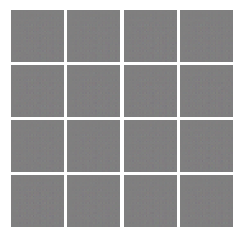


Iter: 0, D: 1.412, G:0.5837
Iter: 50, D: 1.483, G:0.6793
Iter: 100, D: 1.403, G:0.663
Iter: 150, D: 1.329, G:0.6595
Iter: 200, D: 1.352, G:0.7605


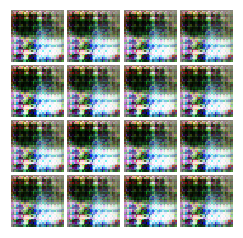


Iter: 250, D: 1.403, G:0.8132
Iter: 300, D: 1.335, G:0.6778
Iter: 350, D: 1.404, G:0.8303
Iter: 400, D: 1.326, G:0.7076
Iter: 450, D: 1.359, G:0.7431


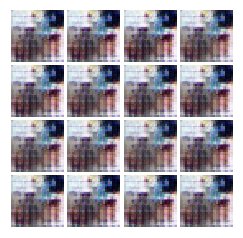


Iter: 500, D: 1.328, G:0.7226
Iter: 550, D: 1.318, G:0.7206
Iter: 600, D: 1.315, G:0.7759
Iter: 650, D: 1.384, G:0.8797
Iter: 700, D: 1.29, G:0.7553


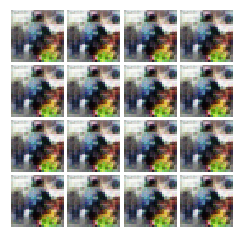


Iter: 750, D: 1.335, G:0.9926


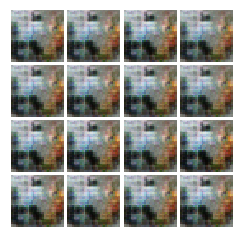


Iter: 0, D: 1.293, G:0.6865
Iter: 50, D: 1.326, G:0.7517
Iter: 100, D: 1.246, G:0.804
Iter: 150, D: 1.267, G:0.8459
Iter: 200, D: 1.304, G:0.7501


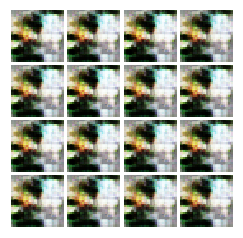


Iter: 250, D: 1.296, G:0.9007
Iter: 300, D: 1.31, G:0.902
Iter: 350, D: 1.369, G:0.8123
Iter: 400, D: 1.283, G:0.9295
Iter: 450, D: 1.397, G:1.193


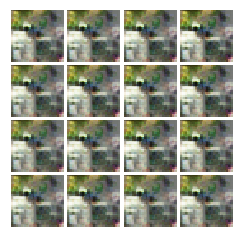


Iter: 500, D: 1.209, G:0.8493
Iter: 550, D: 1.218, G:0.9641
Iter: 600, D: 1.245, G:0.896
Iter: 650, D: 1.193, G:0.9125
Iter: 700, D: 1.237, G:1.062


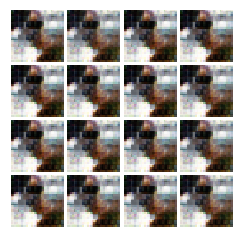


Iter: 750, D: 1.266, G:0.887


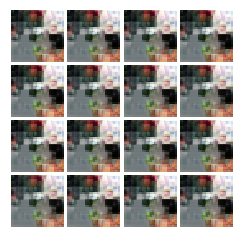


Iter: 0, D: 1.251, G:0.849
Iter: 50, D: 1.165, G:0.8757
Iter: 100, D: 1.094, G:1.145
Iter: 150, D: 1.138, G:1.046
Iter: 200, D: 1.162, G:0.9368


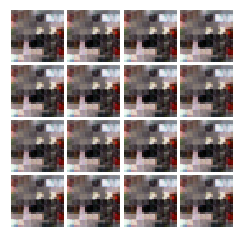


Iter: 250, D: 1.084, G:0.94
Iter: 300, D: 1.12, G:0.9742
Iter: 350, D: 1.174, G:0.9405
Iter: 400, D: 1.333, G:1.076
Iter: 450, D: 1.245, G:1.186


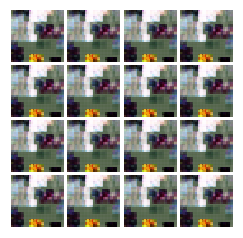


Iter: 500, D: 1.182, G:1.136
Iter: 550, D: 1.164, G:1.018
Iter: 600, D: 1.126, G:1.156
Iter: 650, D: 1.161, G:0.9153
Iter: 700, D: 1.07, G:1.123


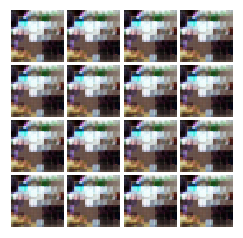


Iter: 750, D: 1.04, G:1.149


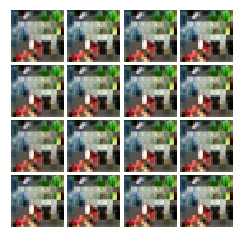


Iter: 0, D: 1.158, G:1.234
Iter: 50, D: 1.073, G:1.027
Iter: 100, D: 0.9551, G:1.438
Iter: 150, D: 1.144, G:0.8766
Iter: 200, D: 1.111, G:1.107


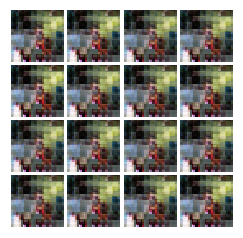


Iter: 250, D: 1.129, G:1.101
Iter: 300, D: 1.041, G:1.361
Iter: 350, D: 1.156, G:1.148
Iter: 400, D: 0.9388, G:1.393
Iter: 450, D: 1.279, G:0.9715


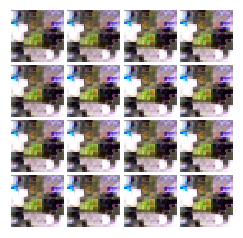


Iter: 500, D: 0.9779, G:1.288
Iter: 550, D: 0.9597, G:1.57
Iter: 600, D: 1.259, G:1.029
Iter: 650, D: 0.9514, G:1.526
Iter: 700, D: 1.089, G:1.186


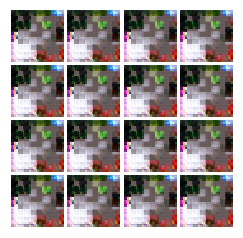


Iter: 750, D: 1.234, G:1.193


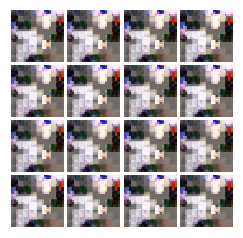


Iter: 0, D: 1.083, G:1.337
Iter: 50, D: 1.097, G:1.336
Iter: 100, D: 1.158, G:1.24
Iter: 150, D: 0.9424, G:1.318
Iter: 200, D: 0.9775, G:1.334


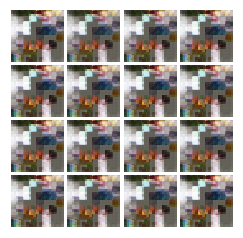


Iter: 250, D: 0.9587, G:1.279
Iter: 300, D: 0.949, G:1.326
Iter: 350, D: 1.152, G:1.257
Iter: 400, D: 1.028, G:1.198
Iter: 450, D: 0.9972, G:1.143


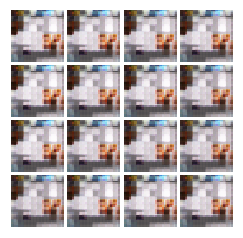


Iter: 500, D: 0.9236, G:1.411
Iter: 550, D: 0.8781, G:1.632
Iter: 600, D: 1.209, G:1.498
Iter: 650, D: 1.087, G:1.444
Iter: 700, D: 0.9567, G:1.549


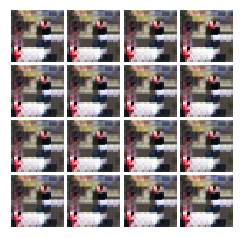


Iter: 750, D: 1.049, G:1.575
Final images


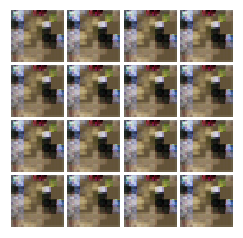

In [109]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step, batch_size=64,num_epoch=5)

# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [16]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        pass
        init = tf.contrib.layers.xavier_initializer(uniform=True)
        x = tf.reshape(x, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(x, 64, kernel_size=4, strides=2, activation=leaky_relu, padding='valid',
                             kernel_initializer=init, name='conv_1')
        x = tf.layers.conv2d(x, 128, kernel_size=4, strides=2, activation=leaky_relu, padding='valid',
                             kernel_initializer=init, name='conv_2')
        x = tf.layers.batch_normalization(x)
        x = tf.reshape(x, [-1, 3200])
        x = tf.layers.dense(x, 1024, activation=leaky_relu, 
                            kernel_initializer=init, name='dense_layer_1')
        logits = tf.layers.dense(x, 1, kernel_initializer=init, name='dense_layer_2')
        return logits
test_discriminator(3411649)

Correct number of parameters in discriminator.


In [17]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [25]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None
    G_loss = -tf.reduce_mean(logits_fake)
    D_loss = tf.reduce_mean(logits_fake - logits_real)
    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform([batch_size,1])
    x_hat = eps * x + (1-eps) * G_sample

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat), x_hat)[0]
    grad_norm = tf.norm(grad_D_x_hat, axis = 1) - 1
    grad_pen = tf.reduce_mean(lam * tf.square(grad_norm))
    
    D_loss += grad_pen


    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

Tensor("Shape:0", shape=(2,), dtype=int32)


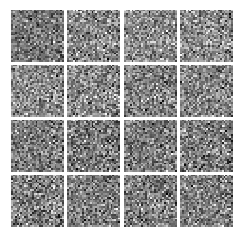


Iter: 0, D: 8.085, G:-0.2222
Iter: 50, D: -21.64, G:10.02
Iter: 100, D: -23.8, G:0.05078
Iter: 150, D: -13.5, G:-12.55
Iter: 200, D: -13.98, G:-7.772


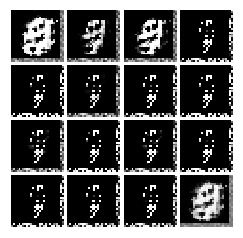


Iter: 250, D: -12.03, G:-12.65
Iter: 300, D: -13.87, G:-11.14
Iter: 350, D: -12.15, G:-11.85
Iter: 400, D: -11.69, G:-1.644
Iter: 450, D: -12.52, G:-1.441


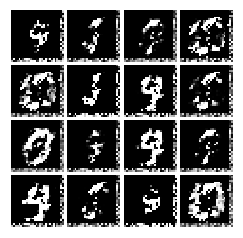


Iter: 500, D: -12.7, G:1.744
Iter: 550, D: -11.65, G:13.87
Iter: 600, D: -10.96, G:16.63
Iter: 650, D: -11.29, G:18.0
Iter: 700, D: -8.342, G:13.72


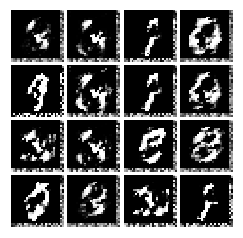


Iter: 750, D: -7.843, G:17.47
Iter: 800, D: -6.17, G:20.04
Iter: 850, D: -4.0, G:9.904
Iter: 900, D: -3.242, G:4.837
Iter: 950, D: -3.626, G:12.39


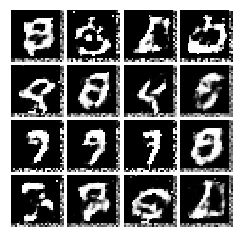


Iter: 1000, D: -3.088, G:3.177
Iter: 1050, D: -2.788, G:12.51
Iter: 1100, D: -2.794, G:10.68
Iter: 1150, D: -2.248, G:8.188
Iter: 1200, D: -2.256, G:3.731


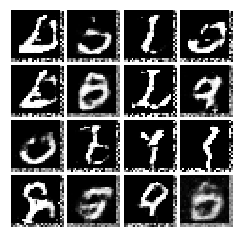


Iter: 1250, D: -1.955, G:8.484
Iter: 1300, D: -2.42, G:3.473
Iter: 1350, D: -2.145, G:3.652
Iter: 1400, D: -1.776, G:8.273
Iter: 1450, D: -2.069, G:2.424


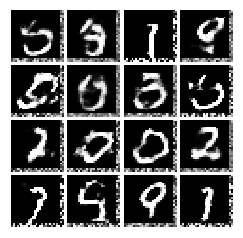


Iter: 1500, D: -1.993, G:8.039
Iter: 1550, D: -1.66, G:-1.438
Iter: 1600, D: -1.791, G:4.545
Iter: 1650, D: -1.356, G:10.19
Iter: 1700, D: -1.803, G:-1.62


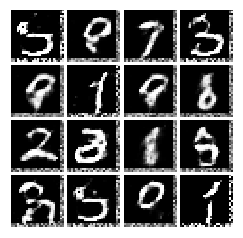


Iter: 1750, D: -1.885, G:2.728
Iter: 1800, D: -1.388, G:-1.671
Iter: 1850, D: -1.28, G:-1.543
Iter: 1900, D: -1.27, G:2.815
Iter: 1950, D: -1.611, G:-0.6823


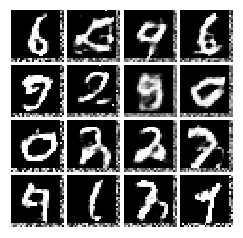


Iter: 2000, D: -1.812, G:-6.814
Iter: 2050, D: -1.942, G:-3.76
Iter: 2100, D: -1.371, G:-6.12
Final images


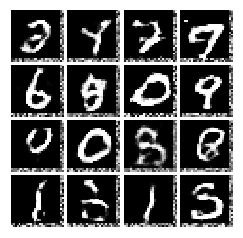

In [26]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=5)